<center> <h1> OTGAN </h1> </center>


This code is an implementation of the OTGAN algorithm, following 2 article :

[1] Tim Salimans, Han Zhang, Alec Radford, and Dimitris Metaxas. **Improving GANs using optimal
transport.** In ICLR, 2018.

[2]Aude Genevay, Gabriel Peyré, Marco Cuturi. **Learning Generative Models with Sinkhorn Divergences** Ocotober 2017

</br>

Following [1], we use the primal formulation of the optimal transport problem, and avoid a bias in the minibatch gradient that can be found in other approaches based on optimal transport. The distance between the generator and the data distribution is measured by the **mini-batch energy distance** introduced in [1], which is "highly discriminative" and stable in the sense of the Nash equilibrium (ie results remain consistant if the discriminator stops being updated). The cost function is learned adversarially by a neural network, the critic.

</br>

Following [2], we adopt a simpler approach more adapted to MNIST simpler data structure. The sinkhorn loss used is very similar as the minibarch energy distance. But we don't learn adversarially the cost function . Ie the cost is directly computed between the original images. Therefore, there is only one generator in the model

In order to test the model, we use **two types of data** : 
- Images based on simulated gaussian mixtures with very apparent modes
- The MNIST digit dataset

We test **two different generator and critic architectures** :
- The architecture suggested by the authors of [1] for the CIFAR dataset
- The architecture suggested by [2] for the MNIST dataset, which led us to better results 

- This notebook is devided in two parts 
  - First we implement [1] and analyse the results 
  - The we implement [2] and demonstrate better results for the generation of MNIST digits 

## Preliminary steps

In [136]:
#if using colab 
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import seaborn as sns 
sns.set(palette='gray')

import os
import argparse
from datetime import datetime

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm
import pickle
! pip install POT
import ot
from torchvision.datasets import VisionDataset
from torchvision import transforms

# PART 1 : IMPLEMENTING [1] :  Improving GANs using optimal transport

### Model parameters and hyperparameters
**Notes** : 
- in this current version, we remove all seeds to make sure the order of the dataloader is random and that the generated noise is not the same
- the authors use a batch size of 8000, which enables to better capture the variety of the data, and to compute lower variance estimates. They reach higher inception scores with respect to a lower batch size (cf Figure 3). Here we stick to a batch size of 128 due to memory limitations

In [75]:
args={}
kwargs={}
args['batch_size']=128
args['val_batch_size']=128
args['n_epochs']=2

# Use the same value as author's for CIFAR for Adam LR and beta values :
args['lr']=3e-4
args['beta1']= 0.5
args['beta2']= 0.999


#entropy regularization 
args['epsilon'] = 1

# args['seed']=1 #random seed
args['cuda']=True if torch.cuda.is_available() else False
device = "cuda" if args['cuda']==True else "cpu"


args["n_gen"] = 3 # number of generator updates per critic update (as in CIFAR's example)

print ('parameters \n')
for key in args.keys():
  print(key, args[key])




parameters 

batch_size 128
val_batch_size 128
n_epochs 2
lr 0.0003
beta1 0.5
beta2 0.999
epsilon 1
cuda True
n_gen 3


## Data preprocessing

###  MNIST dataset

- Mnist (train set ) : 60000  gray scaled images representing digits of size 28 x 28
Usps in the train set. 
- All pixels have value between 0 and 1 
- Here, we  resize images to 32x32 in order to implement exactly the same architecture as the author's (in [1] Appendix B) on CIFAR
- Note that this architecture may be too complex for a data set like MNIST 

In [4]:
### Load the trainset 

path_data = '/content/drive/My Drive/optimal_transport/data'  #where to download data
path = '/content/drive/My Drive/optimal_transport/' #where to save pickle with trained model
#path_data = '../data/MNIST'

# Define dataset transformation
transform = transforms.Compose([transforms.ToTensor()
                              ])

# ## Preliminary step : download dataset
trainset = torchvision.datasets.MNIST(root=path_data, train=True, transform=transform)


trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/optimal_transport/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Size of the input image :  torch.Size([1, 28, 28])


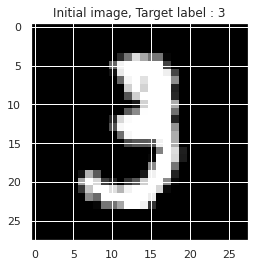

In [5]:
### Plot an example of digit

index = 10
print("Size of the input image : ",trainset[index][0].size())
plt.imshow(trainset[index][0].view(trainset[index][0].size()[1],trainset[index][0].size()[2]), cmap='gray')
plt.title("Initial image, Target label : "+str(trainset[index][1]))
plt.show()

#### Train and validation loaders

In [0]:
train_loader = DataLoader(trainset, args['batch_size'], shuffle=True, **kwargs)


#### Resize  to obtain 32x32 images

- We need to get images of this size to use the same architecture as in the article 

In [0]:
### resized trainset
resized_transform = transforms.Compose([
                    transforms.Resize(32), 
                    transforms.ToTensor()])
trainset_resized = datasets.MNIST(root = path_data, download=True, train=True, transform=resized_transform )


#### Train loaders

In [0]:
# Define resized loader
train_resized_loader = DataLoader(trainset_resized, args['batch_size'], shuffle=True, **kwargs)

mnist shape resized  torch.Size([128, 1, 32, 32])


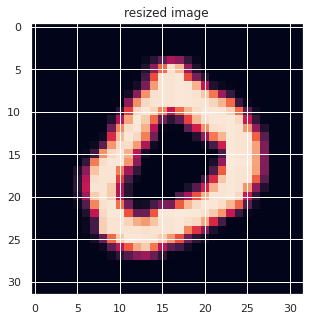

In [9]:
## Plot padded and resized images
dataiter_mnist_resized = iter(train_resized_loader)
images_mnist_resized, _ = dataiter_mnist_resized.next()
print('mnist shape resized ', images_mnist_resized.shape) 

plt.figure(figsize=(5,5))
plt.imshow(images_mnist_resized[0].numpy().squeeze())
plt.title('resized image')
plt.show()

### Create gaussian mixture 'images'

In order to test a "toy" case, we generated **samples following a mixture of gaussian with $m$ gaussians centered around a circle of diameter 1, and equally spaced**, and a covariance matrix $\frac{1}{50}I_{d}$. This sampling procedure enables to obtain $m$ modes which are quite well separated for a value $m$ which is not too big (eg $m=4$ to ), but not completely distinct. These samples are then **turned into black and white images by discretizing the sample space**, into a 32x32 grid in our case.

In [0]:
def simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes = 4):
    '''Simulate gaussian mixture with nb_modes modes arranges around the unit circle
    Inputs :
    cov_mixt_ratio : the ratio by which the identity is divided when defining the covariance matrix
    size_mixt : the size of the vector for EACH gaussian. #number of points generated for each gaussian
    nb_modes : the number of gaussiam  mixtures
    Outputs : 
    a numpy array of dimension (size_mixt*nb_modes , 2)
    '''
    val = np.arange(0,2*np.pi,np.pi/(nb_modes/2)) 
    x_val = np.cos(val)
    y_val = np.sin(val)
    mixture = []
    for i in range(len(val)):
        mixture.append(np.random.multivariate_normal(mean = [x_val[i],y_val[i]], cov = np.identity(2)/cov_mixt_ratio, size = size_mixt))

    mixture_vect = mixture[0]
    for i in range(1,len(val)):
        mixture_vect = np.concatenate([mixture_vect,mixture[i]])
    return mixture_vect

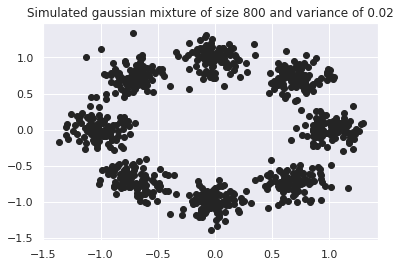

In [39]:
nb_modes = 8
size_mixt = 100
cov_mixt_ratio = 50 #aparent modes but not too separeted
mixture_vect = simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes)
plt.scatter(mixture_vect[:,0],mixture_vect[:,1])
plt.title("Simulated gaussian mixture of size "+str(nb_modes*size_mixt)+" and variance of "+str(1/cov_mixt_ratio))
plt.show()

The simulated gaussian mixtures need to be converted to an image. 

In [0]:
def array_to_img(array, img_size, return_normalized = False):
    """Function
    array : an array of dimension Kx2
    img_size : the dimension of the (squared) image obtained
    return_normalized : also return the normalized array (for comparison)
    """
    mixture_norm = array+np.abs(np.min(array))
    mixture_norm = mixture_norm/(np.max(mixture_norm)-np.min(mixture_norm))
    round_array = np.round(mixture_norm*(img_size-1))
    gauss_img = np.zeros((img_size,img_size))
    for i in range(round_array.shape[0]):
        gauss_img[int(round_array[i,:][0]),int(round_array[i,:][1])] = 255
    if return_normalized == False :
        return gauss_img
    else :
        return gauss_img, mixture_norm

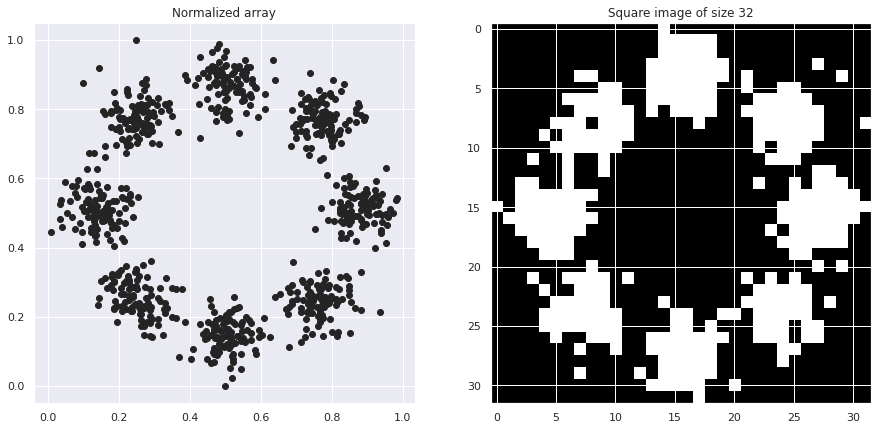

In [77]:
img_size = 32
# img_size = 28
gauss_img, mixture_norm = array_to_img(mixture_vect, img_size, return_normalized = True)

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(mixture_norm[:,0],mixture_norm[:,1])
ax[0].set_title('Normalized array')
ax[1].imshow(gauss_img, cmap=plt.cm.gray)
ax[1].set_title('Square image of size '+str(img_size))
plt.show()

In [0]:
class GaussianMixtureDB(VisionDataset):
    '''Class with gaussian mixture data'''
    def __init__(self, dataset):
        self.images = dataset
        self.target = [0 for i in range(len(dataset))]
        self.root = "add/pickle/location"
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
        return img, target

In [125]:
# args["batch_size_Gauss"] = 200
args["batch_size_Gauss"] = 128
# size_GaussianMixtureDB = 30*args["batch_size_Gauss"]
size_GaussianMixtureDB = 500*args["batch_size_Gauss"]
print("Size of the dataset : ",size_GaussianMixtureDB)
print("Number of modes : ",nb_modes)
GaussianMixture_array = [simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes) for i in range(size_GaussianMixtureDB)]
GaussianMixture_imgs = [torch.tensor(np.expand_dims(array_to_img(array, img_size, return_normalized = False),axis=0)).float() for array in GaussianMixture_array]
GaussianMixture_trainset = GaussianMixtureDB(GaussianMixture_imgs)
GaussianMixture_loader = DataLoader(GaussianMixture_trainset, args['batch_size_Gauss'], shuffle=True, **kwargs)
GaussianMixture_trainset

Size of the dataset :  64000
Number of modes :  8


Dataset GaussianMixtureDB
    Number of datapoints: 64000
    Root location: add/pickle/location

In [0]:
try :
    del GaussianMixture_array
#     del GaussianMixture_imgs
except :
    print("deleted")

## Define GAN's architecture

### Generator

#### Authors' generator architecture
The Generator32x32 architecture corresponds to Table 3 of [1]

As showed in the article for the CIFAR dataset : we use a $Uniform([-1,1])$ to generate noise



In [0]:
class _UpBlock_Generator(nn.Module):
    '''
    Class used in the Generator architecture
    Defines the 2xNN upsample, convolution and GLU for a given input size in_channels
    Input size : [bs, in_channels, n, n]
    Output size : [bs, in_channels/2, 2*n, 2*n]
    '''
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 2*in_channels, out_channels = 2*in_channels, 
                              kernel_size = 5, padding=2, stride = 1)
        torch.nn.init.xavier_uniform_(self.conv.weight) #xavier init
        #in_channels = 2*initial dimension because NN upsampler multiplies by 2 height and width

    def forward(self, x: Tensor) -> Tensor:
        x =  F.interpolate(x, scale_factor=(2,2), mode = "nearest") #multiplies by 2
        x = self.conv(x)
        x = F.glu(x,dim=1) #GLU activation devides by 2 the number of channels
        return x

In [0]:
class Generator32x32(nn.Module):
    '''Class defining the Generator with the same architecture as used by Salimans. et al. for the CIFAR dataset
    Input : 
    input_dim : dimension of the noise z
    out_channels : number of colour channel (1 by default for greyscale images)
    
    '''
    def __init__(self, input_dim: int=100, out_channels = 1):
        super(Generator32x32, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=32768)
        torch.nn.init.xavier_uniform_(self.linear.weight)
        #need to define out features = 2*16384 because glu devides by 2 the number of units
        self.up1 = _UpBlock_Generator(512) 
        self.up2 = _UpBlock_Generator(256)
        self.up3 = _UpBlock_Generator(128)
        self.last_conv = nn.Conv2d(in_channels = 128, out_channels = out_channels, kernel_size = 5, padding=2, stride = 1)
        torch.nn.init.xavier_uniform_(self.last_conv.weight)
        self.input_dim = input_dim
    
    def generate_noise(self, bs):
        ''' Generate noise with dimension [bs, k] following a Uniform([-1,1])'''
        z = (torch.rand([bs, self.input_dim], requires_grad = True)*2)-1
        return z
    
    def forward(self, x: Tensor):
        bs = x.size()[0]
        ## Linear layer and reshape
        x1 = self.linear(x) 
        x1_a = F.glu(x1) 
        assert x1_a.size() == (bs, 16384)
        x2 = x1_a.reshape(bs,1024,4,4) # size [bs, 1024, 4, 4] 
        assert x2.size() == (bs, 1024, 4, 4)
        ## Up blocks : upsample, convolution and GLU
        x3 =  self.up1(x2) # size [bs, 512, 8, 8]
        assert x3.size() == (bs, 512, 8, 8)
        x4 =  self.up2(x3) # size [bs, 256, 16, 16]
        assert x4.size() == (bs, 256, 16, 16)
        x5 =  self.up3(x4) # size [bs, 128, 32, 32]
        assert x5.size() == (bs, 128, 32, 32)
        
        ## last convolution and activation
        x6 = self.last_conv(x5) # size [bs, 1, 32, 32]
        x7 = torch.tanh(x6) 
        out = x7 # size [bs, 1, 32, 32]
        assert out.size() == (bs, 1, 32, 32)
        return out 

### Generate noise 

noize shape torch.Size([1, 100])


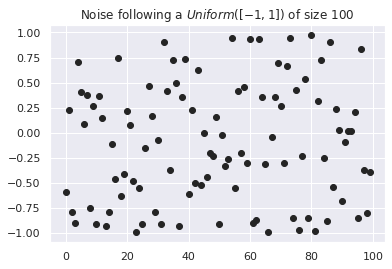

In [0]:
# # Initialize random seed
# torch.random.manual_seed(args['seed'])

# Define generator model
generate = Generator32x32(input_dim=100)

# Generate noise of given batch size

# z = generate.generate_noise(bs = args["batch_size"], k = k)
z = generate.generate_noise(bs = 1)
print('noize shape', z.size())


# Scatter one example of noise
plt.scatter(range(100),z[0].detach())
plt.title("Noise following a $Uniform([-1,1])$ of size "+str(100)) 
plt.show()

In [0]:
# Test the output of the generator network
z = generate.generate_noise(bs = 10)
print(z.size())
generator_output = generate(z)
print("Output size : ",generator_output.size())
#print(generator_output)

torch.Size([10, 100])
Output size :  torch.Size([10, 1, 32, 32])


### Critic / Discriminator

#### Authors' Critic architecture
The Critic32x32 architecture is based on the Table 4 of [1]

- Concatenated ReLU has two outputs, one ReLU and one negative ReLU, concatenated together. In other words, for an input vector x, CRelu(x) =$[(x)_+ ; (-x)_+] = [Relu(x);Relu(-x)]$. Because it has two outputs, CReLU doubles the output dimension.
- The critic aims here at learning the cost function c in section 4. (we will defined it later )


In [0]:
class _DownBlock_Critic(nn.Module):
    '''
    Class used in the Critic architecture
    Defines the convolution and CReLU 
    Input size : [bs, in_channels, n, n]
    Output size : [bs, in_channels*2, n/2, n/2]
    Inputs : 
    in_channels : int
    '''
    def __init__(self, in_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, 
                              kernel_size = 5, padding=2, stride = 2)
        torch.nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x: Tensor) -> Tensor:
        x =  self.conv(x) 
        x = torch.cat((self.relu(x),self.relu(-x)),dim=1) #doubles the outpout dimension
        return x

In [0]:
class Critic32x32(nn.Module):
    '''Class defining the critic with the same architecture as used by Salimans. et al. for the CIFAR dataset
    Input : 
    nb_channels : number of channels in the image (in particular, 1 or 3 ?)
    
    '''
    def __init__(self, nb_channels: int=1):
        super(Critic32x32, self).__init__()
        self.relu=nn.ReLU()
        self.init_conv = nn.Conv2d(in_channels = nb_channels, 
        out_channels = 128, kernel_size = 5, padding = 2, stride = 1) 
        torch.nn.init.xavier_uniform_(self.init_conv.weight)
        self.down1 = _DownBlock_Critic(256)
        self.down2 = _DownBlock_Critic(512)
        self.down3 = _DownBlock_Critic(1024)
        
        
    def forward(self, x: Tensor):
        bs = x.size()[0]
        ## Initial convolution and CReLU
        x1 = self.init_conv(x) # size [bs, 128, 32, 32]
        assert x1.size() == (bs, 128, 32, 32)
        x2 = torch.cat((self.relu(x1),self.relu(-x1)),dim=1) #size [bs, 256, 32, 32]
        assert x2.size() == (bs, 256, 32, 32)
        ## Apply down block three times
        x3 = self.down1(x2) # size [bs, 512, 16, 16]
        assert x3.size() == (bs,  512, 16, 16)
        x4 = self.down2(x3) # size [bs, 1024, 8, 8]
        assert x4.size() == (bs, 1024, 8, 8)
        x5 = self.down3(x4) # size [bs, 2048, 4, 4]
        assert x5.size() == (bs, 2048, 4, 4)
        ## Reshaping and l2 normalization
        x5_reshape = x5.reshape(bs, 32768) # size [bs, 32768]
        assert x5_reshape.size() == (bs, 32768)
#         x5_norm = (torch.norm(x5_reshape, p=2, dim=1)+1e-10).view(bs,1) # size [1, bs]
        x5_norm = (torch.norm(x5_reshape, p=2, dim=1)).view(bs,1) # size [1, bs] #l2 normalization
        assert x5_norm.size() == (bs, 1)
        out = x5_reshape/(x5_norm) # size [bs, 32768]
        assert out.size() == (bs, 32768)
        return out

In [104]:
# Test with the first batch images from train_pad_loader
iterator = enumerate(train_resized_loader)
batch_idx, (imgs, targets) = next(iter(iterator))
critic = Critic32x32(nb_channels=1)
critic_output = critic(imgs)
print("Critic output size : ",critic_output.size())


Critic output size :  torch.Size([128, 32768])


## Training

- We use the algorithm 1 of [1]
- The loss is a combination of optimal transport theory (with the sinkhorn distance ) and of an energy distance . It's called : Mini batch energy distance  and is defined as : 
$$\mathcal{L} = \mathcal{W}_c(X, Y) + \mathcal{W}_c(X, Y') + \mathcal{W}_c(X', Y) + \mathcal{W}_c(X', Y') - 2\mathcal{W}_c(X, X') - 2\mathcal{W}_c(Y, Y')$$
Where X and X' are independant batches of real images and Y and Y' are independant batches of fake images i.e generated by the generator.
$\mathcal{W}_c(X, Y)$ is the sinkhorn distance defined in equation (5) . Or as we described it in class : 
$$
 \mathcal{W}_c(X, Y) =    \min_{P \in   \mathcal{M}  }\langle C, P \rangle + \epsilon \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
- where $C \in \mathbb{R}^{K \times K}$ is the cost matrix between each vector of batches X and Y. (K vectors per batch). It will be define by the cosine distance 
- $\epsilon$ is the minimum entropy required for the coupling P 
- $\mathcal{M}$  is the set of all couplings ie all the columns and rows of P must sum to 1. In class we had the set $\mathcal{U}(a,b)$. Here a and b $\in \mathbb{R}^K$ and $\forall i =1 \dots K, a_i = b_i = 1$

### Sinkhorn minibatch distance

Pytorch implementation : https://github.com/dfdazac/wassdistance/blob/master/layers.py 


In [0]:
def sinkhorn_distance(C, epsilon=1, max_iters=100, a = "default", b = "default", detach = True, device = device):
    """Sinkhorn's distance
    Inputs : 
    C the cost matrix (a torch tensor) of size K x K between batch X (K images) and batch Y (K images)
    epsilon : the regularization parameter of the Entropy-regularized Optimal Transport problem
    default value = 500 as in the article
    max_iters : number of iterations for the Sinkhorn's algorithm
    a : either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    b : either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    
    Output : the Sinkhorn distance between minibatch vectors X and Y
    """

    # Note : in our case we should have m = n (= K in the article's notations) if minibatches are of identical size
    n = C.size()[0]
    m = C.size()[1]
    
    ## Initialize a and b if necessary
    if a == "default":
        a = torch.ones([n], dtype=torch.float64)/n
    if b == "default":
        b = torch.ones([m], dtype=torch.float64)/m
    
    a = a.to(device)
    b = b.to(device)

    if detach == True : 
        ## Stop gradient propagation during the computation of the distance
        with torch.no_grad():

            ## Compute the kernel matrix K
            K = torch.exp(-C/epsilon)

            ## Alternate projections
            v = torch.ones([b.size()[0]])
            v = v.to(device)

            for _ in range(max_iters):
                u = a / torch.matmul(K.double(),v.double())
                v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

            ## Compute the matching matrix
            M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
            return torch.sum(M*C)
    else :
    ## Compute the kernel matrix K
        K = torch.exp(-C/epsilon)

        ## Alternate projections
        v = torch.ones([b.size()[0]])
        v = v.to(device)

        for _ in range(max_iters):
            u = a / torch.matmul(K.double(),v.double())
            v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

        ## Compute the matching matrix
        M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
        return torch.sum(M*C)

In [0]:
#check our function 
C = torch.randn(3,3)
a = torch.ones(3)/3
b = torch.ones (3)/3
print('value of POT package', ot.sinkhorn2(a,b,C,reg=1))
print('value of Pytorch function', sinkhorn_distance(C.to(device), epsilon=1, detach=True, device=device))

value of POT package [-0.79760915]
value of Pytorch function tensor(-0.7976, device='cuda:0', dtype=torch.float64)


### Cosine distance and Mini Batch energy distance
The cost of transportation between to images is defined by the cosin distance. But, as previously explained, it's learned adversarially bu the critic which embed the images in a higher dimension space. Therefore,  it can adapt to the generator distribution g and  become more discriminative. 

According to article [1] section 4: 
$$c_\eta(x, y) = 1 - \frac{v_\eta(x). v_\eta(y)}{||v_\eta(x)||_2 ||v_\eta(y)||_2}$$
where $v_\eta(x)$ is the mapping of image x by the critic ie a vector of dimension 32768 which is way superior to the dimension of our data. Therefore, this mapping doesn't reduce the dimension 


In [0]:
## Define the cosine similarity for torch tensors with 2 dimensions (including batch size)

# Cosine similarity defined just for verification purpose
cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-08)

def cos_dist(X,Y):
    '''Cosine distance between 
    Inputs : torch tensors of size [bs,n]
    Output : torch tensor of size [bs, bs]
    '''
    X_norm = X / X.norm(dim=1)[:, None]
    Y_norm = Y / Y.norm(dim=1)[:, None]
    cos_dist = 1- torch.mm(X_norm, Y_norm.transpose(0,1))
    return cos_dist



def loss_cos_dist(X, Xp, Y, Yp, epsilon = 0.1, detach = False):
# def loss_cos_dist(X, Xp, Y, Yp, epsilon = 0.1, detach = True):
    '''Compute the loss of the OTGAN when the cost function is the cosine distance (cf Appendix D)
    Inputs : 
    X and Xp minibatches of real data
    Y and Yp minibatches of synthesized data
    detach : a boolean, whether or not to propagate gradient through Sinkhorn's distance calculation

    Returns 
    loss_g = loss of the generator which corresponds to the 4 first terms in algorithm 1 
    loss_c = loss of the critic (2 last termes) 
    (will be useful to monitor separately the performances of the critic and the generator)
    loss = total loss ie loss_g - loss_d
    '''

    

    #loss of the generator 
    loss_g = sinkhorn_distance(cos_dist(X,Y), epsilon=epsilon, detach=detach) 
    loss_g += sinkhorn_distance(cos_dist(X,Yp), epsilon=epsilon, detach=detach) 
    loss_g += sinkhorn_distance(cos_dist(Xp,Y), epsilon=epsilon, detach=detach)
    loss_g += sinkhorn_distance(cos_dist(Xp,Yp), epsilon=epsilon, detach=detach)

    #loss of the discriminator 
    loss_c = 2*sinkhorn_distance(cos_dist(X,Xp), epsilon=epsilon, detach=detach)
    loss_c += 2*sinkhorn_distance(cos_dist(Y,Yp), epsilon=epsilon, detach=detach)

    #total loss
    loss = loss_g - loss_c

    return loss, loss_g, loss_c

### Training Loop

/!\

- We follow the algorithm 1 of [1]
- Note that countrary to standard practice, the generator is more updated than the critic to ensure the loss doesn't become degenerate
- Alternatively (but more often for the generator ), a gradient descent is performed to update the generator and a gradient ascent is performed to update the critic . This is a min max problem
- save both generator & critic's infos to allow warm starts 


#### Issue : 
- if detach == False : then we backpropagate the gradients (!= what the authors seem to do)
- if detach == True : error, no gradient exists so backward is not possible

In [0]:
mnist_loader = train_resized_loader 

In [0]:
#saving and loading checkpoints
import shutil

def save_ckp(state,  checkpoint_dir=path, 
             checkpoint_name='checkpoint_otgan_v3.pt'):
    """
    Saves the state of model
    params : state : dictionnary of checkpoint with the models and optimizers parameters
    checkpoint_dir : directory for saving the checpoint
    checkpoint_name : name of the checkpoint 
    """
    f_path = checkpoint_dir + checkpoint_name
    torch.save(state, f_path)
   
    

def load_ckp(checkpoint_fpath, model, optimizer,  device=device):
    '''
    load models from a given checkpoint 
    '''
    checkpoint = torch.load(checkpoint_fpath,  map_location=torch.device(device))

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return  model, optimizer,  checkpoint['epoch'], checkpoint['loss_history']

In [0]:
def training_loop(args = args,  
                  dataloader = mnist_loader, 
                  verbose=True, 
                  warm_start=False, device=device,
                  path=path, checkpoint_name='checkpoint_otgan_v4',
                  plot_digit=True, use_images=False):
  
    '''
    Define the training of the OTGAN 

    Parameters : 
    args: dictionnary of arguments for training such as batch size etc 
    dataloader : dataloader of mnist images 
    verbose : Boolean : wether to print monitoring values during one epoch 
    warm_start : boolean : wether to resume the training of a precedent model 
    path : working directory 
    checkpoint_name : name of the checkpoint 

    Returns : the trained Generator and Critic and generated images
    '''
    ##################################

    #.       Initialization

    ##################################

   

    print("----------Author's architecture-----------")
    # generator = Generator32x32(input_dim=100).to(device)
    generator = Generator32x32(input_dim=2).to(device)
    critic = Critic32x32().to(device)
    
    

    #get parameters of generator (\theta in the article)
    #get parameters of critic (\eta in the article )
    g_params = list(generator.parameters())
    c_params = list(critic.parameters())

    #initialze the optimizers
    #optimizer of the generator . 
    #At each gradient step, only the gradient of the loss wrt theta will be substracted
    optimizer_G = optim.Adam(g_params, args['lr'], [args['beta1'], args['beta2']])
    #optimizer of the critic
    optimizer_C = optim.Adam(c_params, args['lr'], [args['beta1'], args['beta2']])

    #loss history 
    loss_history = []

    if warm_start:
      ckp_path = path + checkpoint_name

      #load generator
      generator, optimizer_G,  previous_epoch, loss_history = load_ckp(ckp_path+'_generator.pt', generator, optimizer_G)
      #load critic 
      critic, optimizer_C,  _, _  = load_ckp(ckp_path+'_critic.pt', critic, optimizer_C)
      start_epoch = previous_epoch+1
      previous_loss = loss_history[-1]
      

      print('\n----------------------')
      print('Warm Start : Resuming training of {} at epoch {} with current loss {}'.format(checkpoint_name, start_epoch, previous_loss))
      print('------------------------')
    else:
      start_epoch = 1 
      print('\n-----------------------')
      print('No warm start')
      print('------------------------')

    #create an iterator for data images 
    iter_X = iter(dataloader)

    #number of iterations per epoch. Depends on batch size
    iter_per_epoch = len(iter_X)

    #batchsize
    bs = args['batch_size']

    #number of epochs 
    n_epochs = args['n_epochs']

    


    #---------------------------------------------------

    #.               TRAINING LOOP

    #---------------------------------------------------
    print('\n-----------------')
    print('LEARNING RATE :', args['lr'])
    print('BETA_1 :', args['beta1'])
    print('BETA_2 :', args['beta2'])
    print('EPSILON :', args['epsilon'])
    print('NUMBER of EPOCHS to complete :', n_epochs)
    print('BATCH_SIZE :', bs)
    print('ITERATION PER EPOCH :', iter_per_epoch, '\n-------------------\n\n\n')

    for epoch in range(start_epoch, start_epoch + n_epochs):
      #iterate over epochs
      #reset data_iter for each epoch
      iter_X = iter(dataloader) #iterator for the X
      iter_Xp = iter(dataloader) #iterator for the X'

      #total loss over all the data for one epoch
      total_loss =[] #loss of algo 1

      #only for monitoring purpose
      total_g_loss = [] #the 4 first terms of loss in algorithm 1 
      total_c_loss =[] #the two last terms 

      for step in tqdm(range(1, iter_per_epoch+1)): #each iteration corresponds to a batch
        
        # get data. Two independant batches
        X, _ = iter_X.next()
        X = X.to(device)
        Xp, _ = iter_Xp.next()
        Xp = Xp.to(device)
        #assert X and X_p different 
        assert (X != Xp).any()


        #get two codes
        Z = generator.generate_noise(bs)
        Z = Z.to(device)
        Zp = generator.generate_noise(bs)
        Zp=Zp.to(device)
        assert (Z != Zp).any()


        #generate synthetic images from codes
        Y = generator(Z)
        Yp = generator(Zp)
        #assert 
        assert (Y != Yp).any()


        ###################################################
    
        #      TRAIN THE GENERATOR AND THE CRITIC

        ###################################################

        
        if use_images == True :
          #brouillon
          #no mapping of the critic in the loss
          X_flat, Xp_flat = X.reshape(bs, -1), Xp.reshape(bs, -1)
          Y_flat, Yp_flat = Y.reshape(bs, -1), Yp.reshape(bs, -1)
          loss, loss_g , loss_c= loss_cos_dist(X_flat, Xp_flat, Y_flat, Yp_flat, epsilon=args['epsilon'])

        else :
          #Get Embed representations of  images into the feature space by using the critic mapping
         
          out_X = critic(X)
          out_Xp = critic(Xp)
         
          out_Y = critic(Y)
          out_Yp = critic(Yp)

          #compute the loss of generator and critic
          loss, loss_g , loss_c= loss_cos_dist(out_X, out_Xp, out_Y, out_Yp, epsilon=args['epsilon'])
         

        #loss_g and loss_c are just respectively
        #the 4 first terms of loss in algorithm 1 
        #the 2 last terms. Just useful for monitoring purpose


        #add to the list of loss for monitoring at the end of each epoch
        total_loss.append(loss.item())
        total_g_loss.append(loss_g.item())
        total_c_loss.append(loss_c.item())


        if step % args["n_gen"] == 0:  #update the critic
          (-loss).backward() #-loss for gradient ascent 
          optimizer_C.step() #take a step of gradients
          #zero the gradients 
          optimizer_C.zero_grad()

        else: #update the generator 
          
          loss.backward()  #gradient descent 
          optimizer_G.step()
          optimizer_G.zero_grad()


        #monitioring discriminator real  loss 
        if (step % 100 == 0) and verbose:
          print('\n, Monitoring of iteration {} of epoch {}'.format(step, epoch))
          print('\n--------------------------')
          print('AVERAGE TOTAL LOSS   : ', np.mean(total_loss))
          print('GENERATOR LOSS ', np.mean(total_g_loss))
          print('CRITIC LOSS ', np.mean(total_c_loss))
          print('--------------------------')

            
      #monitoring at the end of each epoch
      print('\n\n EPOCH {} completed'.format(epoch))
      print('MONITORING', '\n--------------------------')
      print('AVERAGE GENERATOR LOSS', np.mean(total_g_loss))
      print('AVERAGE CRITIC LOSS', np.mean(total_c_loss))
      print('AVERAGE TOTAL LOSS :' , np.mean(total_loss))
      if plot_digit == True :
        print("Generated digits after epoch "+str(epoch))
        with torch.no_grad():
          n=4
          image_size=32
          z = generator.generate_noise(n).to(device)
          images = generator(z)
          images.size()
          images = images.reshape(n, 1, image_size,image_size)

          fig, ax = plt.subplots(1,n, figsize=(10, 5))
          for i in range(n):
            img = images[i].cpu()
            ax[i].imshow(img.numpy().squeeze(), cmap='gray')

      print('--------------------------')

      print('SAVING')
      print('--------------------------')

      #saving  checkpoint for future warm starts 
      loss_history.append(np.mean(total_loss))

      #check if model is best so far
      if loss_history[-1] == np.min(loss_history):
        is_best = True
      else:
        is_best = False
      print('best so far ', is_best)
      checkpoint_g = {
          'epoch':epoch,
          'args':args,
          'loss_history':loss_history,
          'model_state_dict': generator.state_dict(),
          'optimizer_state_dict':optimizer_G.state_dict()}
      save_ckp(checkpoint_g,   checkpoint_dir=path, 
               checkpoint_name = str(checkpoint_name+'_generator.pt'))

      checkpoint_c = {
          'epoch':epoch,
          'args':args,
          'loss_history':loss_history,
          'model_state_dict': critic.state_dict(),
          'optimizer_state_dict':optimizer_C.state_dict()
      }
      save_ckp(checkpoint_c, checkpoint_dir=path, 
               checkpoint_name = checkpoint_name+'_critic.pt')


    trained_model = {'critic':critic, 'generator' :generator}
    return trained_model

    
   

### Train some models 

- Refaire tourner l'ancienne archi en changeant l'espace latent. Dimension plus faible et on va de 0 à 1 


----------Author's architecture-----------

-----------------------
No warm start
------------------------

-----------------
LEARNING RATE : 0.0003
BETA_1 : 0.5
BETA_2 : 0.999
EPSILON : 1
NUMBER of EPOCHS to complete : 2
BATCH_SIZE : 128
ITERATION PER EPOCH : 469 
-------------------






, Monitoring of iteration 100 of epoch 1

--------------------------
AVERAGE TOTAL LOSS   :  0.035690430699193094
GENERATOR LOSS  0.03918442415982122
CRITIC LOSS  0.003493993460628126
--------------------------

, Monitoring of iteration 200 of epoch 1

--------------------------
AVERAGE TOTAL LOSS   :  0.017877098642648814
GENERATOR LOSS  0.019648732012946066
CRITIC LOSS  0.0017716333702972537
--------------------------

, Monitoring of iteration 300 of epoch 1

--------------------------
AVERAGE TOTAL LOSS   :  0.011928310208686281
GENERATOR LOSS  0.01312455155387099
CRITIC LOSS  0.001196241345184711
--------------------------

, Monitoring of iteration 400 of epoch 1

--------------------------
AVERAGE TOTAL LOSS   :  0.008950559449935546
GENERATOR LOSS  0.009858535198447033
CRITIC LOSS  0.0009079757485114882
--------------------------



 EPOCH 1 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 0.008416002594280943
AVERAGE CRITIC LOSS 0.0007805466861076623
A


, Monitoring of iteration 100 of epoch 2

--------------------------
AVERAGE TOTAL LOSS   :  8.650808867175613e-06
GENERATOR LOSS  4.9294359145631094e-05
CRITIC LOSS  4.06435502784555e-05
--------------------------

, Monitoring of iteration 200 of epoch 2

--------------------------
AVERAGE TOTAL LOSS   :  7.5518846347145625e-06
GENERATOR LOSS  4.788307543325023e-05
CRITIC LOSS  4.033119079853568e-05
--------------------------

, Monitoring of iteration 300 of epoch 2

--------------------------
AVERAGE TOTAL LOSS   :  6.677565461267531e-06
GENERATOR LOSS  4.667014627108539e-05
CRITIC LOSS  3.999258080981786e-05
--------------------------

, Monitoring of iteration 400 of epoch 2

--------------------------
AVERAGE TOTAL LOSS   :  6.002477689839901e-06
GENERATOR LOSS  4.559749933842377e-05
CRITIC LOSS  3.959502164858387e-05
--------------------------



 EPOCH 2 completed
MONITORING 
--------------------------
AVERAGE GENERATOR LOSS 4.504702261584388e-05
AVERAGE CRITIC LOSS 3.9416972

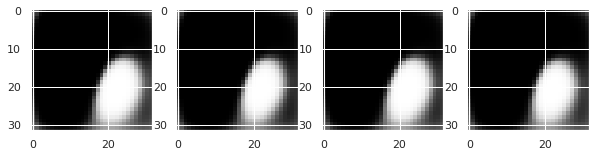

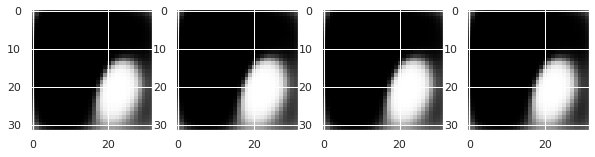

In [37]:
trained_model = training_loop(args = args,  
                  dataloader = mnist_loader, 
                  verbose=True, 
                  warm_start=False, device=device,
                  path=path, checkpoint_name='checkpoint_otgan_v2_dim16',
                  plot_digit=True, use_images=False)

## Testing the images generated 

In [0]:
def plot_gen_images(checkpoint_path, generator, image_size=28,
                    plot_history=False, n=4, device = device):
    '''
    plot images generated by a given model

    Parameters
    checkpoint_path : path where the model is saved
    generator : initial model
    image_size : either 28 or 32
    '''
    checkpoint = torch.load(checkpoint_path, map_location = torch.device(device)) #load in cpu mode by default
    try:
      args = checkpoint['args']
      print('args \n')
      for arg in list(args.keys()):
        if arg == 'n_epochs':
          print(arg, checkpoint['epoch']) 
          #args[n_epochs] = number of epochs to complete for training 
          #if warmstart, different from checkpoint[n_epochs] = total_number of epochs
        else:
          print(arg, args[arg])
    except:
      pass

    generator.load_state_dict(checkpoint['model_state_dict'])
    with torch.no_grad():
      z = generator.generate_noise(n)
      images = generator(z)
      images = images.reshape(n, 1, image_size,image_size)
      

      fig, ax = plt.subplots(1,n, figsize=(10, 5))
      for i in range(n):
        img = images[i]
        ax[i].imshow(img.numpy().squeeze(), cmap='gray')
      if plot_history:
        plt.figure(figsize=(10,5))
        plt.plot(checkpoint['loss_history'])
        plt.title('Loss evolution')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

#### Test on the MNIST dataset

args 

batch_size 128
val_batch_size 128
n_epochs 2
lr 0.0003
beta1 0.5
beta2 0.999
epsilon 1
cuda True
n_gen 3


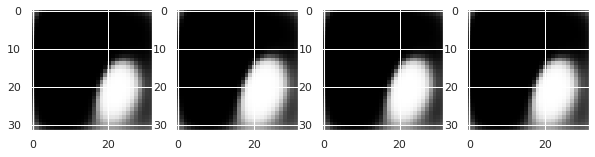

In [146]:

checkpoint_path = path + 'checkpoint_otgan_v2_dim16_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator32x32(input_dim=16), image_size=32)


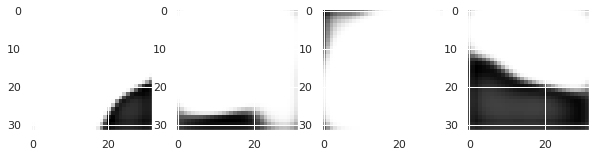

In [0]:
checkpoint_path = path + 'checkpoint_otgan_v3_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator32x32(), image_size=32)
#forgott the loss history at beginning

#### Test on the Gauss dataset

args 

batch_size 128
val_batch_size 128
n_epochs 2
lr 0.0003
beta1 0.5
beta2 0.999
epsilon 1
cuda True
n_gen 3
batch_size_Gauss 128


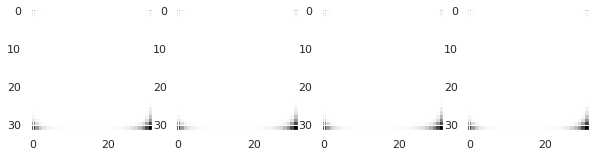

In [148]:

checkpoint_path = path +"checkpoint_otgan_v2_dim16_Gauss_generator.pt"
plot_gen_images(checkpoint_path, generator=Generator32x32(input_dim=16), image_size=32)


### Observations : 
- We don't have any digits 
- The architecture may be too complicated for MNIST 
- (Re run to have loss history )


# PART 2 : IMPLEMENTING [2] Learning Generative Models with Sinkhorn Divergences

- We now implement for MNIST a new network way more simpler (see details below ) 
- The loss, use, the Sinkhorn divergence, is very similiar to the mini batch energy distance , but we don't sample independant batches. 
- One other major difference is that, as the cost is not learned adversarially by a critic, we only need to train a generator, whose quality is directly assessed by the Sinkhorn divergence between images generated by the the network and real ones 


### Models and hyperparameters

In [46]:
args={}
kwargs={}
args['batch_size']=200
args['n_epochs']=10


args['lr']=1e-4
args['beta1']= 0.9
args['beta2']= 0.999


#entropy regularization 
args['epsilon'] = 1
args['sinkhorn_iter'] = 100

# args['seed']=1 #random seed
args['cuda']=True if torch.cuda.is_available() else False
device = "cuda" if args['cuda']==True else "cpu"



print ('parameters \n')
for key in args.keys():
  print(key, args[key])




parameters 

batch_size 200
n_epochs 10
lr 0.0001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda True


## Data preprocessing

In [0]:
### Load the trainset 

path_data = '/content/drive/My Drive/optimal_transport/data'  #where to download data
path = '/content/drive/My Drive/optimal_transport/' #where to save pickle with trained model

# Define dataset transformation
transform = transforms.Compose([transforms.ToTensor(),
                              ])
#do not resize this time 

trainset = torchvision.datasets.MNIST(root=path_data, train=True, transform=transform)


trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/optimal_transport/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [0]:
mnist_loader = DataLoader(trainset, args['batch_size'], shuffle=True, **kwargs)
iter_X = iter(mnist_loader)
X, _ = iter_X.next()
print(X.size())

torch.Size([200, 1, 28, 28])


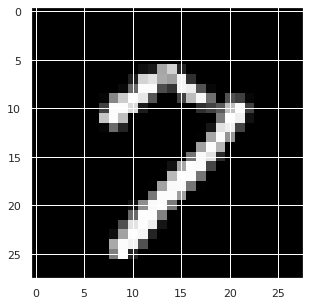

In [0]:
plt.figure(figsize=(5,5))
plt.imshow(X[0].numpy().squeeze(), cmap='gray')
plt.show()

## Architecture : Only one Generator 

- we follow the architecture proposed in [2] for the MNIST dataset 

- MLP with two fully connected layers 
- 1 hidden layer of 500 units 
- one output layer of size 28*28 
- Xavier initialization for the weights. We remind the formula for Xavier initialization : Each weight of a layer is initialized following a zero normal distribution with variance $\sqrt{\frac{2}{n_i +n_o}}$ with $n_i$ and $n_o$ respectively the number of inputs and  outputs of the layer. It has been demonstrated empirically that it yields to better stability during training. 

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size=2, hidden_dim=500, output_size=28*28):
      super(Generator, self).__init__()
      
      # 1
      self.fc1 = nn.Linear(input_size, hidden_dim)
      torch.nn.init.xavier_uniform_(self.fc1.weight) #xavier initialization
      self.fc2 = nn.Linear(hidden_dim, output_size)
      torch.nn.init.xavier_uniform_(self.fc2.weight) 
      self.input_size = input_size

    def generate_noise(self, bs):
        ''' Generate noise with dimension [bs, input_size] following a Uniform([0,1])'''
        z = torch.rand(bs, self.input_size)
        return z

    def forward(self, x):
      bs = x.size(0) #batch size
      x = self.fc1(x)
      assert x.size() == (bs, 500)
      out = self.fc2(x)
      assert out.size() == (bs, 28*28)
      return out

In [0]:
generator= Generator()
z = generator.generate_noise(200)
print(z.size())
y = generator(z)
print(y.size())

torch.Size([200, 2])
torch.Size([200, 784])


## Training 

### define losses 

We define the Sinkhorn Divergence as in [2]
$$\mathcal{L} = 2\mathcal{W}_c(X, Y)  - \mathcal{W}_c(X, X) -  \mathcal{W}_c(Y, Y)$$
where X is a batch of real images and Y is a batch of synthetic images. Note that countrary to the Mini batch energy distance defined in [1], we don't sample independant batches X and X'
- here,  $c$ is a fixed cost, either the cosin distance or the squared euclidean distance. We decided to use the cosin distance countrary to the article because the sinkhorn algorithm sometimes computed a distance = 'nan'.. (see below) 

In [0]:
def euclidean_dist(X,Y):
    '''
    X and Y : vectors of size (bs, n) with bs = batch size and n = dimension of vector 
    Returns : 
    C matrix of shape (bs, bs)
    '''
    return ((X[:, None] - Y)**2).sum(axis=2)

def cos_dist(X,Y):
    '''Cosine distance between 
    Inputs : torch tensors of size [bs,n]
    Output : torch tensor of size [bs, bs]
    '''
    X_norm = X / X.norm(dim=1)[:, None]
    Y_norm = Y / Y.norm(dim=1)[:, None]
    cos_dist = 1- torch.mm(X_norm.double(), Y_norm.transpose(0,1).double())
    return cos_dist

In [0]:
def loss_cos_dist2(X, Y,  epsilon = 1, max_iters = 10, detach = False):
# def loss_cos_dist(X, Xp, Y, Yp, epsilon = 0.1, detach = True):
    '''Compute the loss of the OTGAN when the cost function is the euclidean distance (cf Appendix D)
    Inputs : 
    X = minibatch of real data
    Y = minibatch of generated data
    detach : a boolean, whether or not to propagate gradient through Sinkhorn's distance calculation

    Returns 
    loss_g = loss of the generator which corresponds to the 4 first terms in algorithm 1 
    loss_c = loss of the critic (2 last termes) 
    (will be useful to monitor separately the performances of the critic and the generator)
    loss = total loss ie loss_g - loss_d
    '''

    

    #loss of the generator 
    loss = 2*sinkhorn_distance(cos_dist(X,Y), epsilon=epsilon, max_iters=max_iters, detach=detach) 
    loss-= sinkhorn_distance(cos_dist(X,X), epsilon=epsilon, max_iters=max_iters, detach=detach) 
    loss-= sinkhorn_distance(cos_dist(Y,Y), epsilon=epsilon, max_iters=max_iters, detach=detach) 

    return loss

In [0]:
X, _ = iter_X.next()
X = X.reshape(200, -1)
generator = Generator()
Z = generator.generate_noise(200)
print(Z.size())
Y = generator(Z)
print(Y.size())
sinkhorn_distance(euclidean_dist(X,Y),epsilon=1, max_iters=100, device='cpu')

torch.Size([200, 2])
torch.Size([200, 784])


tensor(nan, dtype=torch.float64)

- Problem with the euclidean distance 
- we will use the cosin distance countrary to the article [2]

### Training loop 2 



In [0]:
def training_loop2(args = args,  
                  dataloader = mnist_loader, 
                  verbose=True, 
                  warm_start=False, device=device,
                  path=path, checkpoint_name='checkpoint_bis_otgan_v1',
                  plot_digit=True):
  
    '''
    Define the training of the OTGAN 

    Parameters : 
    args: dictionnary of arguments for training such as batch size etc 
    dataloader : dataloader of mnist images 
    verbose : Boolean : wether to print monitoring values during one epoch 
    warm_start : boolean : wether to resume the training of a precedent model 
    path : working directory 
    checkpoint_name : name of the checkpoint 

    Returns : the trained Generator and Critic and generated images
    '''
    ##################################

    #.       Initialization

    ##################################

   
    #initialize generator
    
    generator = Generator().to(device)

    #get parameters of generator (\theta in the article)
  
    g_params = list(generator.parameters())

    #initialze the optimizer
    #optimizer of the generator . 
    #At each gradient step, only the gradient of the loss wrt theta will be substracted
    optimizer_G = optim.Adam(g_params, args['lr'], [args['beta1'], args['beta2']])

    #loss history 
    loss_history = []

    if warm_start:
      ckp_path = path + checkpoint_name

      #load generator
      generator, optimizer_G,  previous_epoch, loss_history = load_ckp(ckp_path+'_generator.pt', generator, optimizer_G)
      start_epoch = previous_epoch+1
      previous_loss = loss_history[-1]
      

      print('\n----------------------')
      print('Warm Start : Resuming training of {} at epoch {} with current loss {}'.format(checkpoint_name, start_epoch, previous_loss))
      print('------------------------')
    else:
      start_epoch = 1 
      print('\n-----------------------')
      print('No warm start')
      print('------------------------')

    #create an iterator for data images 
    iter_X = iter(dataloader)

    #number of iterations per epoch. Depends on batch size
    iter_per_epoch = len(iter_X)

    #batchsize
    bs = args['batch_size']

    #number of epochs 
    n_epochs = args['n_epochs']

    


    #---------------------------------------------------

    #.               TRAINING LOOP

    #---------------------------------------------------
    print('\n-----------------')
    print('LEARNING RATE :', args['lr'])
    print('BETA_1 :', args['beta1'])
    print('BETA_2 :', args['beta2'])
    print('EPSILON :', args['epsilon'])
    print(' SINKHORN ITERATION :', args['sinkhorn_iter'])
    print('BATCH_SIZE :', bs)
    print('NUMBER of EPOCHS to complete :', n_epochs)
    print('ITERATION PER EPOCH :', iter_per_epoch, '\n-------------------\n\n\n')

    for epoch in range(start_epoch, start_epoch + n_epochs):
    #for epoch in range(1):
      #iterate over epochs
      #reset data_iter for each epoch
      iter_X = iter(dataloader) #iterator for the X

      #total loss over all the data for one epoch
      total_loss =[] #loss of algo 1


      for step in tqdm(range(1, iter_per_epoch+1)): #each iteration corresponds to a batch
      #for step in range(1):
        #for p in generator.parameters():
          #if p.requires_grad:
            #print(p.name, p.data)
        # get data. Two independant batches
        X, _ = iter_X.next()
        X = X.to(device)
        X = X.reshape(bs, -1) #flatten
        assert X.size() == (bs, 28*28)

        #get a code 
        Z = generator.generate_noise(bs)
        Z = Z.to(device)
        #generate a synthetic images from codes
        Y = generator(Z)
        #print(Y)



        ###################################################
    
        #      TRAIN THE GENERATOR AND THE CRITIC

        ###################################################

          #compute the loss of generator and critic
        loss =  loss_cos_dist2(X, Y,  epsilon=args['epsilon'], max_iters=args['sinkhorn_iter'])
        
        total_loss.append(loss.item())

        #update the optimizer 
        
        loss.backward() 
        optimizer_G.step()
        optimizer_G.zero_grad()



        #monitioring discriminator real  loss 
        if (step % 100 == 0) and verbose:
          print('\n, Monitoring of iteration {} of epoch {}'.format(step, epoch))
          print('\n--------------------------')
          print('AVERAGE TOTAL LOSS   : ', np.mean(total_loss))
          #print('GENERATOR LOSS ', np.mean(total_g_loss))
          #print('CRITIC LOSS ', np.mean(total_c_loss))
          print('--------------------------')

            
      #monitoring at the end of each epoch
      print('\n\n EPOCH {} completed'.format(epoch))
      print('MONITORING', '\n--------------------------')
      #print('AVERAGE GENERATOR LOSS', np.mean(total_g_loss))
      #print('AVERAGE CRITIC LOSS', np.mean(total_c_loss))
      print('AVERAGE TOTAL LOSS :' , np.mean(total_loss))
      if plot_digit == True :
        print("Generated digits after epoch "+str(epoch))
        with torch.no_grad():
          n=4
          image_size=28
          z = generator.generate_noise(n).to(device)
          images = generator(z)
          images.size()
          images = images.reshape(n, 1, image_size,image_size)

          fig, ax = plt.subplots(1,n, figsize=(10, 5))
          for i in range(n):
            img = images[i].cpu()
            ax[i].imshow(img.numpy().squeeze(), cmap='gray')

      print('--------------------------')

      print('SAVING')
      print('--------------------------')

      #saving  checkpoint for future warm starts 
      loss_history.append(np.mean(total_loss))

      #check if model is best so far
      if loss_history[-1] == np.min(loss_history):
        is_best = True
      else:
        is_best = False
      print('best so far ', is_best)
      checkpoint_g = {
          'epoch':epoch,
          'args':args,
          'loss_history':loss_history,
          'model_state_dict': generator.state_dict(),
          'optimizer_state_dict':optimizer_G.state_dict()}
      save_ckp(checkpoint_g,   checkpoint_dir=path, 
               checkpoint_name = str(checkpoint_name+'_generator.pt'))
   

    

    trained_model = {'generator' :generator}
    return trained_model

    
   

### Train some models

- We test different combinations of hyper parameters 
- In [2], nonetheless, details about Adam optimizer are not given as well as the number of epochs for training. We decided to stop the training when the loss didn't decrease anymore 
- Considering the parameters epsilon (regularization entropy ) , the number of sinkhorn iterations (L in the article ) and the batch size (m), we tested the same frameworks ie : 
  - $\epsilon = 1$, batch size = 200 and L = 10 (or 100) 
  - $\epsilon = 0.1$, batch size = 200, L = 100
  - $\epsilon = 0.1$, batch size = 10, L=300$




In [0]:
args['lr'] = 0.001
args['beta1'] = 0.9
args['epsilon'] = 1
args['sinkhorn_iter'] = 10

In [0]:
args

{'batch_size': 200,
 'beta1': 0.9,
 'beta2': 0.999,
 'cuda': True,
 'epsilon': 1,
 'lr': 0.001,
 'n_epochs': 10,
 'sinkhorn_iter': 10}

In [0]:

trained_model = training_loop2(args=args,
                              dataloader=mnist_loader,
                              verbose=False,
                              warm_start=True,
                              plot_digit=False, 
                              checkpoint_name='checkpoint_bis_otgan_v8')


----------------------
Warm Start : Resuming training of checkpoint_bis_otgan_v8 at epoch 11 with current loss 0.07128610100412662
------------------------

-----------------
LEARNING RATE : 0.001
BETA_1 : 0.9
BETA_2 : 0.999
EPSILON : 1
 SINKHORN ITERATION : 10
BATCH_SIZE : 200
NUMBER of EPOCHS to complete : 10
ITERATION PER EPOCH : 300 
-------------------








 EPOCH 11 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07131661942519936
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 12 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07133187524375276
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 13 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.0713788892593654
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 14 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.0711902899640423
--------------------------
SAVING
--------------------------
best so far  True





 EPOCH 15 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07127068017806214
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 16 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07120353149181828
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 17 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07116058092652114
--------------------------
SAVING
--------------------------
best so far  True





 EPOCH 18 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07123072019232786
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 19 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07117021951603543
--------------------------
SAVING
--------------------------
best so far  False





 EPOCH 20 completed
MONITORING 
--------------------------
AVERAGE TOTAL LOSS : 0.07119021225358597
--------------------------
SAVING
--------------------------
best so far  False


## Testing different models

#### Test on the MNIST dataset

args 

batch_size 200
n_epochs 10
lr 0.0001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda False


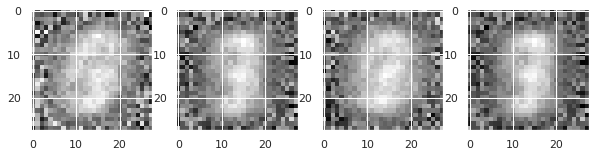

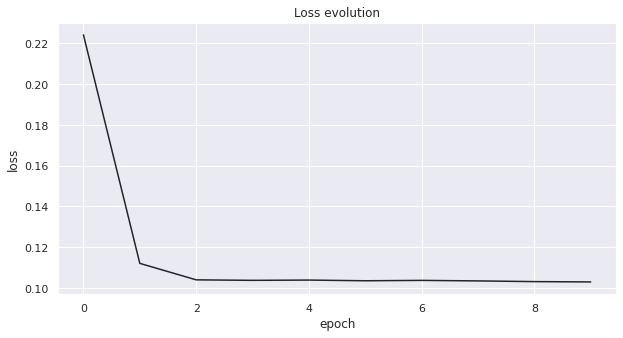

In [0]:
checkpoint_path = path + 'checkpoints_bis_otgan_v1_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 200
n_epochs 20
lr 0.001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda False


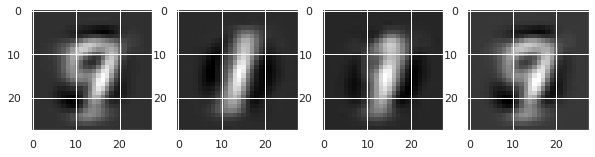

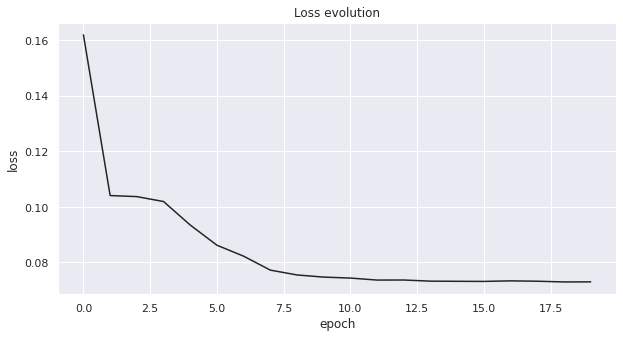

In [0]:
#reducing the learning rate
checkpoint_path = path + 'checkpoint_bis_otgan_v2_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 200
n_epochs 20
lr 0.001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 10
cuda False


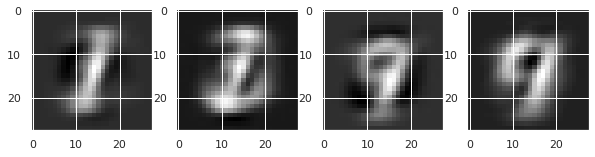

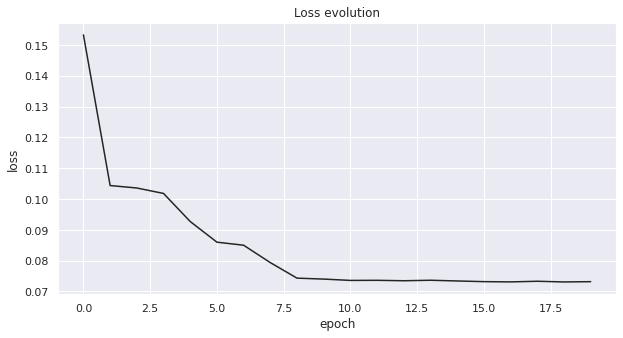

In [0]:
# reducing sinkhorn iterates 
checkpoint_path = path + 'checkpoint_bis_otgan_v3_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 200
n_epochs 10
lr 0.001
beta1 0.9
beta2 0.999
epsilon 0.1
sinkhorn_iter 100
cuda False


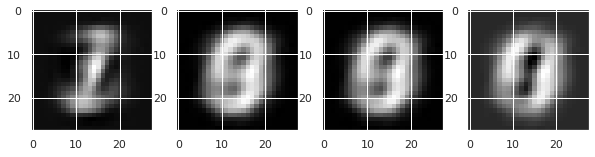

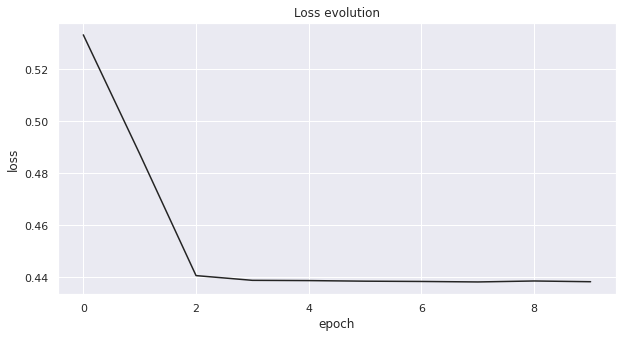

In [0]:
checkpoint_path = path + 'checkpoint_bis_otgan_v4_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 200
n_epochs 10
lr 0.01
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda False


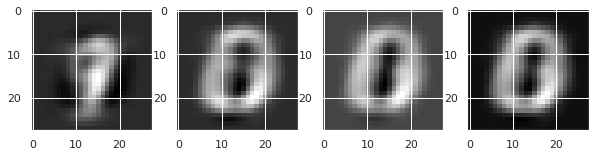

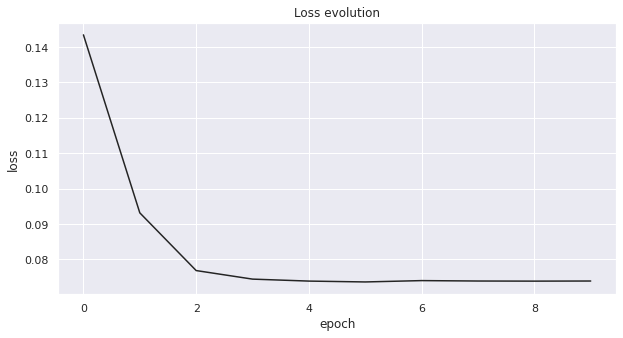

In [0]:
checkpoint_path = path + 'checkpoint_bis_otgan_v5_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 200
n_epochs 10
lr 5e-05
beta1 0.5
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda False


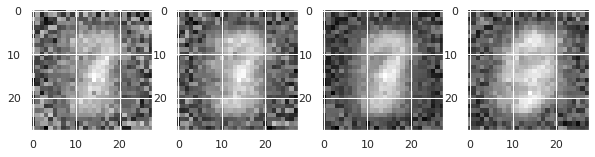

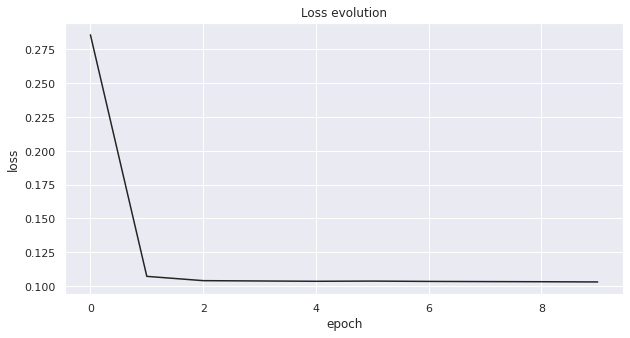

In [0]:
checkpoint_path = path + 'checkpoint_bis_otgan_v6_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 10
n_epochs 11
lr 0.001
beta1 0.9
beta2 0.999
epsilon 0.1
sinkhorn_iter 300
cuda False


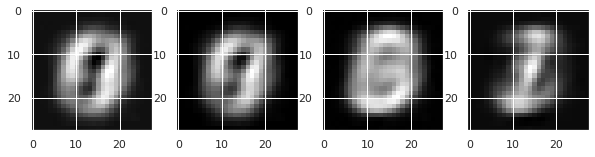

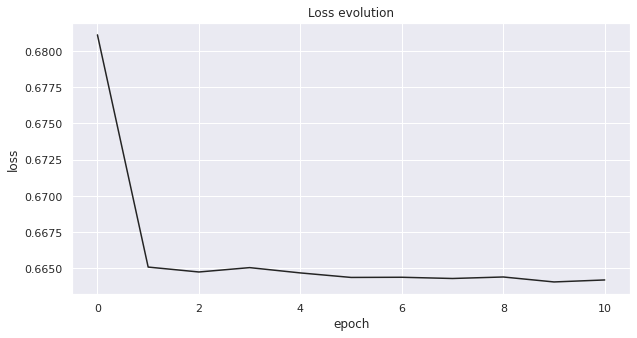

In [0]:
checkpoint_path = path + 'checkpoint_bis_otgan_v7_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

### Exploration of the latent space 

In [0]:
def plot_interpolation(checkpoint_path, generator, image_size=28, n=20):
    '''
    plot images generated by a given model

    Parameters
    checkpoint_path : path where the model is saved
    generator : initial model
    image_size : either 28 or 32
    n :  number of points to slice each dimension of the square [0,1]
    '''
    checkpoint = torch.load(checkpoint_path) #load in cpu mode by default
    try:
      args = checkpoint['args']
      print('args \n')
      for arg in list(args.keys()):
        print(arg, args[arg])
    except:
      pass

    generator.load_state_dict(checkpoint['model_state_dict'])

    fig, ax = plt.subplots(n,n, figsize=(20, 20))
    fig.subplots_adjust(wspace=0, hspace=0)
    with torch.no_grad():
      Z = torch.linspace(0,1, n)
      for i in range(n):
        for j in range(n):
          z = torch.tensor([[Z[i], Z[j]]])
          img = generator(z)
          img = img.reshape(1, 1, image_size, image_size)
          ax[i,j].imshow(img.numpy().squeeze(), cmap='gray')
          ax[i,j].axis('off')
    plt.show()

args 

batch_size 200
n_epochs 10
lr 0.001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda False


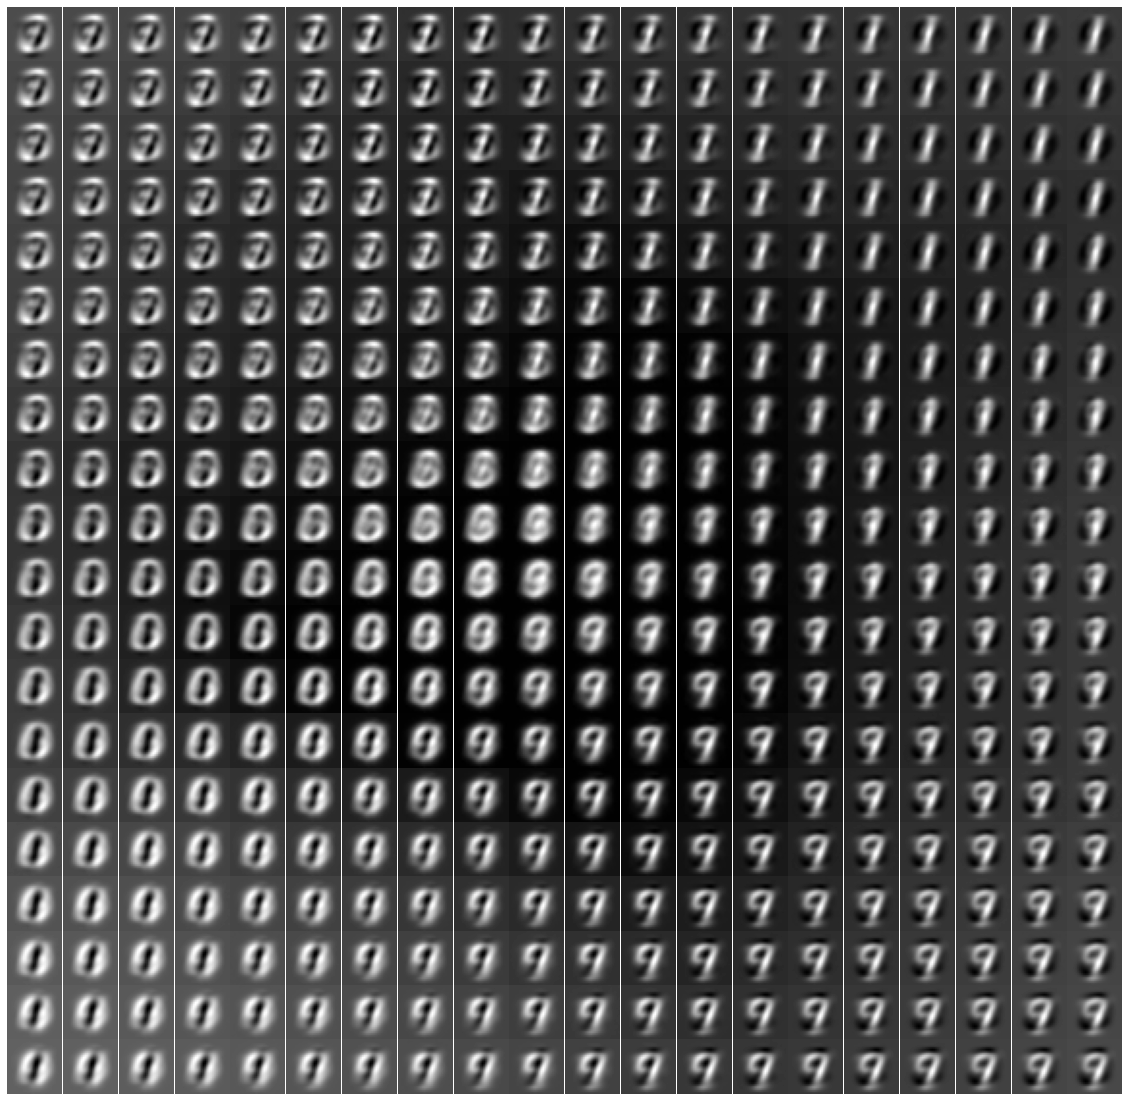

In [0]:
checkpoint_path = path + 'checkpoint_bis_otgan_v2_generator.pt'
plot_interpolation(checkpoint_path, Generator(), n=20)

- Some digits are not generated 
- Smooth transitions
- But we have kind of a Collapsing mode because not all the digits are generated

#### Test with Gauss dataset

args 

batch_size 200
n_epochs 10
lr 0.0001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda True
batch_size_Gauss 200


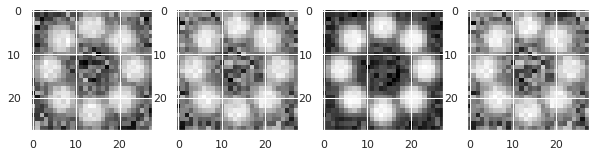

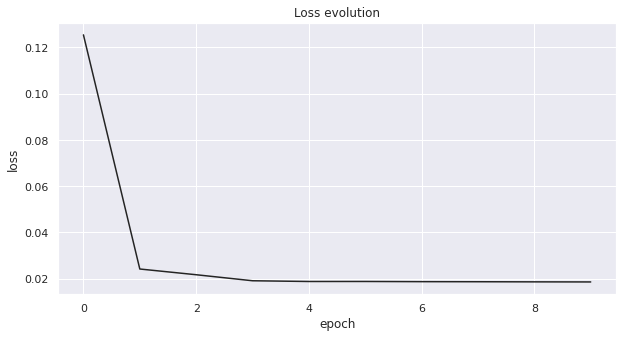

In [73]:
checkpoint_path = path + 'checkpoint_bis_otgan_Gauss_v2_generator.pt'
plot_gen_images(checkpoint_path, generator=Generator(), plot_history=True)

args 

batch_size 200
n_epochs 10
lr 0.0001
beta1 0.9
beta2 0.999
epsilon 1
sinkhorn_iter 100
cuda True
batch_size_Gauss 200


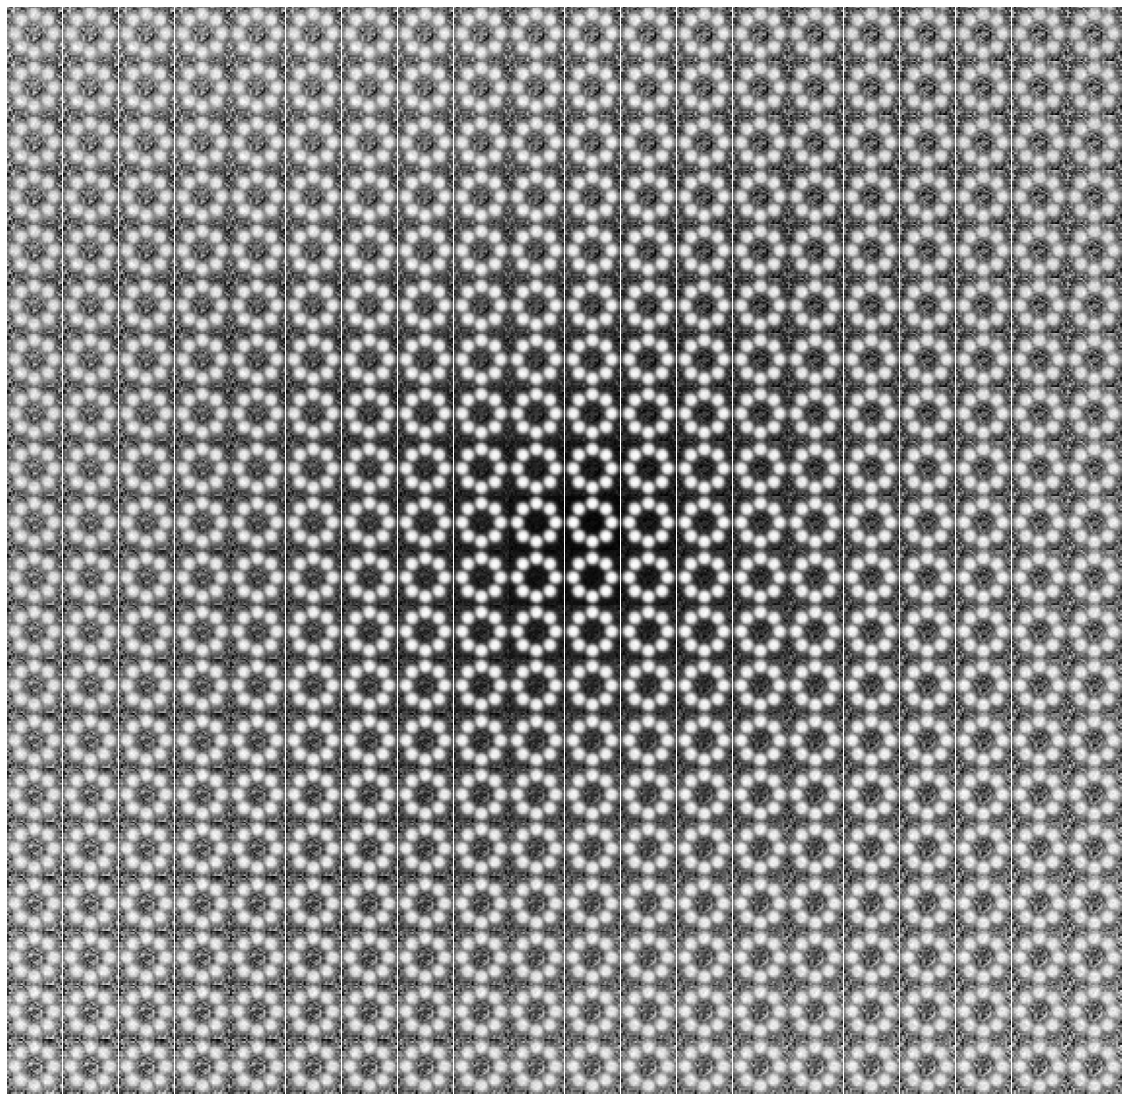

In [74]:
plot_interpolation(checkpoint_path, Generator(), n=20)

### Observations 
- smaller learning rate seems to be better 
- Better use a large $\epsilon$ like $\epsilon = 1$ as suggested in [2]. It leads to faster convergence and doesn't reduce the performances . Indeed, the evolution of the loss is smoother .
- Our generator stops learning quite fast. There might be a problem of vanishing gradient. (use ReLU or leaky Relu ? batch normalization ? ) 
- Collapsing mode ==> Some digits are not generated . We can generate, 9, 1, 0, and it seems to be some 7 and 8. Note that the generator always generate the same 9 and the same 1 for examples 
Apparemment la batch normalization améliore aussi le problème (cf article DCGAN en deep learning )

## Test the OT GAN 

- inception score ??
- v3 = same architecture and  hyperparameters as in the article
  - 8 epochs : Stop learning after 5 epochs approximatively .
  - last loss : 0.00115
- v4 : architecture found on medium, eps = 0.1. generator and discriminator perform equally after a certain number of epochs, loss even reached 0 : idea try to reduce the number ms to suof updates of the discriminator. Seems to suffer from the collapse mode...Even after 18 epochs it's not better.
- v5 : ngen = 6, very unstable . Also mode collapsing 
- v6 : beta1 = 0.5, negative loss at epoch 8 but after increased again 
- v7 same as v6 with lr = 0.0002. Afterb7 epochs loss started to increase...
- v8 : idea : go back to eps = 500? increase max_iter to 500?
- v9 : eps = 500, max_iter = 500, n_gen=6
- v10 : eps = 500, max_iter = 500, n_gen=2
- v12 : test GaussianMixture DB with new architecture

- new architecture training more instable. But faster and it seems to generate digits. But always the same one ..

- IDEA for next architecture : don't use linear layer but convolutional and deconvolutional layers 

# TO TEST 
- tester detach = True pour sinkhorn ?
- utiliser uniquement les images et pas l'espace latent pour tout l'entraînement ? 
- utiliser un n_gen non constant ? 
- 

- Article de Marco : 
- Les poids sont bien normalisés dans sinkhorn
- 'a relatively strong regularization—a large ε—leads not only to more stable results but also faster convergence, so that the value for L can be set quite low.'
- 'we clip the weights φ (the critic mapping) to ensure a bounded gradient in the maximization and use RMSProp as an optimizer'. Voir les refs [1] et [24] dans les ref pour la training procedure 
- Contrairement au premier article, Marco update plus le critic que le generateur 
- Il utilise RMSPROP
- enlever les require grad = True sur les inputs ca ne sert à rien. Normal ques les grqdients soient nuls car il faut faire w.grad où w est un paramètre !! donc loss_g.grad c'est normal que yait rien 
<a href > lien </a>
- faire zero_grad avant loss.backward? Pour éviter d'accumuler les gradients 


# Conclusion
- what we did :
  - try 2 different architectures
  - try the MNIST and simulated gaussian datasets
- what we observe : 
  - degenerated loss
- difficult training :
  - high sensitivity to fine tuning 
  - memory limitations, implies lower batch size
  - very long training when using the CIFAR architecture described in the authors' paper

# Next ?
- try to fix discriminator at one point and continue training to see if producted images are "constant"
- compare performance with padding VS resizing
- look at inception score, as mentionned in the article
- compare performance for different number of modes for gaussian mixture ?  